# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [2]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd        251G   12G  227G   5% /
Disk space is sufficient: 227G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [3]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [4]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 net net 2.0G Jun  3 09:49 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [1]:
%%bash
cargo install hyperfine

    Updating crates.io index
  Downloaded hyperfine v1.19.0
  Installing hyperfine v1.19.0
    Updating crates.io index
     Locking 137 packages to latest compatible versions
      Adding colored v2.2.0 (available: v3.0.0)
      Adding indicatif v0.17.4 (available: v0.17.11)
      Adding nix v0.29.0 (available: v0.30.1)
      Adding rand v0.8.5 (available: v0.9.1)
  Downloaded anstyle v1.0.10
  Downloaded cfg_aliases v0.2.1
  Downloaded is_terminal_polyfill v1.70.1
  Downloaded equivalent v1.0.2
  Downloaded autocfg v0.1.8
  Downloaded lazy_static v1.5.0
  Downloaded clap_lex v0.7.4
  Downloaded bytecheck_derive v0.6.12
  Downloaded ptr_meta_derive v0.1.4
  Downloaded number_prefix v0.4.0
  Downloaded wyz v0.5.1
  Downloaded ptr_meta v0.1.4
  Downloaded tinyvec_macros v0.1.1
  Downloaded anstyle-parse v0.2.6
  Downloaded rand_core v0.3.1
  Downloaded strsim v0.11.1
  Downloaded uuid v1.17.0
  Downloaded funty v2.0.0
  Downloaded anstream v0.6.18
  Downloaded itoa v1.0.15
  Downloaded 

有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [2]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     388.8 ms ±  46.8 ms    [User: 6.9 ms, System: 364.0 ms]
  Range (min … max):   322.8 ms … 456.6 ms    10 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [5]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt
  Time (abs ≡):        1428.469 s               [User: 304.326 s, System: 1053.676 s]
 


## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [3]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):     708.9 ms ±  28.5 ms    [User: 98.8 ms, System: 576.3 ms]
  Range (min … max):   676.2 ms … 754.3 ms    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

1.将缓冲区对齐到系统内存页边界（通常是4KB）可能提高性能，原因如下：
如果缓冲区跨越页边界或者没有对齐，内核可能需要进行额外的内存拷贝或合并操作，以将其整理成与硬件（如磁盘控制器，其通常也以块或页为单位操作）交互的对齐单元。这会增加CPU开销和延迟,对齐时，操作系统内核在处理I/O请求时更容易直接操作这些内存页。
许多现代硬件设备使用DMA直接在内存和设备之间传输数据，而无需CPU的直接干预。DMA控制器通常要求内存缓冲区是物理上连续的，并且按特定边界（如页边界）对齐。对齐的缓冲区更容易满足DMA的要求，从而提高数据传输效率。
我的实验结果mycat3 平均耗时 693.1ms，mycat2 平均耗时 708.9ms,在一定程度上支持了这个猜想。这表明即使对于这个相对简单的 cat 操作，内存对齐也可能带来微小的性能改善，可能是由于内核处理对齐缓冲区的效率稍高。

2.标准C库函数 malloc 的设计目标是提供通用的动态内存分配，它保证返回的指针满足存储任何C标准数据类型的最小对齐要求（例如，在64位系统上通常是8字节或16字节对齐）。然而，malloc 并不保证返回的地址会与更大的边界（如系统页大小，通常为4KB或更大）对齐，原因如下：
堆管理元数据开销：malloc 的实现（如ptmalloc, jemalloc, tcmalloc）为了管理堆内存，会在分配的内存块附近存储内部簿记信息（元数据），例如块大小、空闲链表指针等。这些元数据本身占据空间，并可能导致返回给用户的有效载荷地址相对于从操作系统获取的大块内存区域的起始地址产生偏移。
内存池与碎片管理策略：malloc 通常采用内存池技术，并维护各种大小的空闲块列表以优化分配速度和减少外部碎片。当请求内存时，malloc 会从合适的空闲块中分割所需大小的内存。该空闲块的起始地址本身不一定是页对齐的，因此从中分割出来的部分自然也难以保证页对齐，即使请求的大小是页大小的整数倍。

3.在自定义的对齐内存分配函数 align_alloc 中，我在分配时将 malloc 返回的原始未对齐指针存储在紧邻对齐后指针之前的一个预定义偏移位置。
align_alloc 实现策略：
向 malloc 请求一块比用户请求大小 (size) 额外多出 alignment - 1 + sizeof(void*) 字节的内存。其中 alignment - 1 用于保证能够找到一个对齐的地址，sizeof(void*) 用于存储原始指针。
设 malloc 返回的指针为 original_ptr。
通过指针运算从 original_ptr + sizeof(void*) 开始的地址空间内，计算出一个满足 alignment 要求的地址 aligned_ptr。
将 original_ptr 的值存储在 (void*)((uintptr_t)aligned_ptr - sizeof(void*)) 的位置。
返回 aligned_ptr 给调用者。
align_free 实现策略：
接收 align_alloc 返回的对齐指针 ptr。
通过从 ptr 回退 sizeof(void*) 字节，读取之前存储的原始 malloc 指针：void* original_ptr = *((void**)((uintptr_t)ptr - sizeof(void*)));。
调用 free(original_ptr) 来释放最初由 malloc 分配的整个内存块。


In [4]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):     693.1 ms ±  29.2 ms    [User: 96.2 ms, System: 567.1 ms]
  Range (min … max):   663.3 ms … 769.0 ms    10 runs
 


## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

1.因为它有助于：
最小化文件系统层面的I/O开销：文件系统以块为基本单位在存储设备上组织和传输数据。若应用程序的I/O请求大小与st_blksize（或其整数倍）对齐，则能更直接地映射到文件系统的操作单元，减少因处理非块对齐或部分块请求（例如，写操作可能触发的“读-修改-写”周期）而产生的额外开销。
提升页面缓存效率：st_blksize 通常与系统的页面大小相关（常为其整数倍或相等）。使应用程序缓冲区大小与这些基本单位协调，有利于数据在用户空间、内核页面缓存和存储设备之间的高效流转，减少不必要的数据分段与合并。
优化文件系统预读机制 (Readahead)：文件系统的预读算法可能会根据st_blksize和访问模式来决定预读的粒度和数量。符合st_blksize的I/O请求模式可能使预读更为有效。

2.注意事项1: 文件系统中的每个文件，块大小不总是相同的。
解决方法： 通过对每个打开的文件描述符fd调用fstat(fd, &file_stat)系统调用，可以获取特定于该文件的file_stat.st_blksize值。这意味着程序可以动态地根据当前操作文件的特性来调整缓冲区大小的决策依据。

注意事项2: 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。
解决方法：
有效性检查：对获取的st_blksize进行基本有效性检查，如确保其大于零。
幂等性检查：检查st_blksize是否为2的整数次幂，例如通过位运算 (st_blksize > 0) && ((st_blksize & (st_blksize - 1)) == 0)。非2的幂的块大小可能指示一个非优化或“虚假”的值。
回退策略：如果st_blksize未通过上述检查，程序应回退到使用一个已知的合理值，如系统页面大小（通过sysconf(_SC_PAGESIZE)获取）或一个预设的默认缓冲区大小。在mycat的实现中，若st_blksize无效，则更多地依赖页面大小或后续任务中确定的最优缓冲区大小。

In [6]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     666.3 ms ±  42.4 ms    [User: 83.1 ms, System: 550.2 ms]
  Range (min … max):   610.9 ms … 732.7 ms    10 runs
 


## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

实验脚本旨在使用dd命令评估不同缓冲区大小对内存到内存数据传输吞吐率的影响，以此模拟I/O操作中系统调用开销与缓冲区大小的关系。

循环测试：使用一系列预设的缓冲区大小（从 4KB 到 2048KB）。

执行基准测试：在每次循环中，使用 dd 命令从一个无限的数据源 (/dev/zero) 读取 2GB 数据，并将其写入/dev/null。

参数调整：脚本迭代一系列缓冲区大小（dd的bs参数），这些大小是基准块大小（4096字节）的预定义倍率（1x, 2x, 4x, ..., 512x）。总传输数据量（2GB）保持恒定，dd的count参数相应调整。

数据采集与可视化：脚本捕获dd报告的平均传输速率，将其转换为GB/s，并记录到CSV文件。随后，使用Python（pandas和matplotlib）绘制吞吐率随缓冲区大小变化的折线图，X轴采用对数刻度（以2为底）以清晰展示趋势。

最终结果：最合适的缓冲区大小为256KB

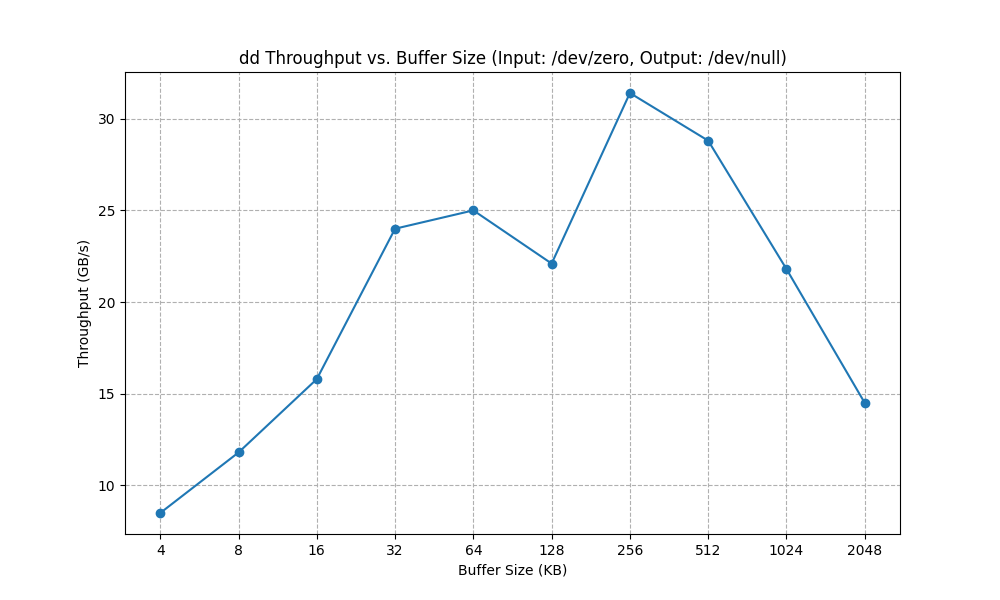

In [ ]:
# 请在这里填入你的测试脚本
#!/bin/bash
#我是在meowhw目录下新建了sh来运行的

echo "Buffer Size (KB),Throughput (GB/s)" > dd_throughput.csv

# Base buffer size from mycat4 (e.g., page size or st_blksize, assume 4KB for this example)
base_buf_size_bytes=4096
# Let's try multipliers that give us common buffer sizes like
# 4K, 8K, 16K, 32K, 64K, 128K, 256K, 512K, 1024K
# Multipliers: 1, 2, 4, 8, 16, 32, 64, 128, 256
multipliers=(1 2 4 8 16 32 64 128 256 512) # Multipliers for base_buf_size
total_data_to_transfer="2G" # Total data to transfer for each test

# Calculate count for dd based on total data and current bs
# For simplicity in parsing dd output, we'll let dd calculate count if bs is given and size is specified for if/of.
# Or, more robustly, calculate count explicitly.
# Size in bytes for 2G = 2 * 1024 * 1024 * 1024
total_data_bytes=$((2 * 1024 * 1024 * 1024))

echo "Running dd tests with various buffer sizes..."

# ... (脚本前面部分不变) ...

for multiplier in "${multipliers[@]}"; do
    current_bs_bytes=$((base_buf_size_bytes * multiplier))
    current_bs_kb=$((current_bs_bytes / 1024))
    
    count=$(( (total_data_bytes + current_bs_bytes - 1) / current_bs_bytes ))

    echo "Testing with buffer size: ${current_bs_kb}KB (Multiplier: ${multiplier}x, bs=${current_bs_bytes}, count=${count})"

    # Run dd and capture stderr (where speed is reported)
    # Force LANG=C to get consistent dd output format if possible
    output=$(LANG=C dd if=/dev/zero of=/dev/null bs=${current_bs_bytes} count=${count} 2>&1 | grep 'bytes.*copied')
    
    if [ -n "$output" ]; then
        # More robust parsing:
        # Example output: "2147483648 bytes (2.1 GB, 2.0 GiB) copied, 0.123 s, 17.4 GB/s"
        # Or: "2147483648 bytes (2.1 GB, 2.0 GiB) copied, 1.234 s, 1740 MB/s"
        
        # Extract the part after the last comma, which contains "speed unit"
        speed_part=$(echo "$output" | awk -F', ' '{print $NF}') # $NF should be "17.4 GB/s" or "1740 MB/s"
        
        speed_value=$(echo "$speed_part" | awk '{print $1}') # "17.4" or "1740"
        speed_unit=$(echo "$speed_part" | awk '{print $2}')  # "GB/s" or "MB/s"

        throughput_gb_s=""

        if [[ "$speed_unit" == "GB/s" ]]; then
            throughput_gb_s=$speed_value
        elif [[ "$speed_unit" == "MB/s" ]]; then
            # Convert MB/s to GB/s using bc for floating point arithmetic
            throughput_gb_s=$(echo "scale=3; $speed_value / 1024" | bc)
        elif [[ "$speed_unit" == "kB/s" || "$speed_unit" == "KB/s" ]]; then # Less likely for /dev/zero to /dev/null
            throughput_gb_s=$(echo "scale=6; $speed_value / 1024 / 1024" | bc)
        else
            echo "Warning: Unknown speed unit '$speed_unit' from dd output: $output"
            throughput_gb_s="ERROR" # Mark as error
        fi
        
        if [[ "$throughput_gb_s" != "ERROR" ]]; then
            echo "${current_bs_kb},${throughput_gb_s}" >> dd_throughput.csv
            echo "Throughput: ${throughput_gb_s} GB/s (Original: $speed_part)"
        else
            echo "${current_bs_kb},ERROR" >> dd_throughput.csv
            echo "Failed to parse throughput from dd output."
        fi
    else
        echo "Failed to get dd output for bs=${current_bs_kb}KB"
        echo "${current_bs_kb},ERROR" >> dd_throughput.csv
    fi
    sleep 1 # Small pause between tests
done

# ... (脚本后面 Python 部分不变) ...
echo "Experiment finished. Results in dd_throughput.csv"
echo "Now plotting the results..."

# Python script to plot the results
python3 - <<END_PYTHON_SCRIPT
import matplotlib.pyplot as plt
import pandas as pd

try:
    data = pd.read_csv('dd_throughput.csv')
    # Ensure throughput is numeric, coercing errors to NaN and dropping them
    data['Throughput (GB/s)'] = pd.to_numeric(data['Throughput (GB/s)'], errors='coerce')
    data.dropna(subset=['Throughput (GB/s)'], inplace=True)

    if not data.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(data['Buffer Size (KB)'], data['Throughput (GB/s)'], marker='o')
        plt.title('dd Throughput vs. Buffer Size (Input: /dev/zero, Output: /dev/null)')
        plt.xlabel('Buffer Size (KB)')
        plt.ylabel('Throughput (GB/s)')
        plt.xscale('log', base=2) # Use log scale for buffer size for better visualization
        plt.xticks(data['Buffer Size (KB)'], data['Buffer Size (KB)'].astype(str)) # Show all x-ticks
        plt.grid(True, which="both", ls="--")
        plt.savefig('dd_throughput_plot.png')
        print("Plot saved as dd_throughput_plot.png")
        # plt.show() # Uncomment to display plot if running in a GUI environment
    else:
        print("No valid data to plot.")
except FileNotFoundError:
    print("Error: dd_throughput.csv not found. Run the bash script first.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

END_PYTHON_SCRIPT

In [ ]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     303.1 ms ±  29.3 ms    [User: 1.7 ms, System: 289.8 ms]
  Range (min … max):   273.8 ms … 380.0 ms    10 runs
 


## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

1. 我使用了 posix_fadvise() 系统调用。针对 cat 这种典型的顺序读取整个文件的应用场景，参数设置如下：
int fd: 这是通过 open() 打开的输入文件的文件描述符 (fd_in)。
off_t offset: 设置为 0。表示建议从文件的起始位置开始应用。
off_t len: 设置为 0。根据 posix_fadvise 的规范，当 len 为0时，建议应用于从 offset 到文件末尾的整个区域。
int advice: 设置为 POSIX_FADV_SEQUENTIAL。这个建议告知内核，应用程序期望按顺序从低地址到高地址读取指定文件区域。
所以调用是：posix_fadvise(fd_in, 0, 0, POSIX_FADV_SEQUENTIAL);
这个调用在文件打开后、开始读取循环之前进行。
此外，在读取完成后、关闭文件之前，我还添加了一个 posix_fadvise(fd_in, 0, 0, POSIX_FADV_DONTNEED); 的调用。这建议内核，应用程序在近期内不再需要访问该文件的数据，因此内核可以考虑将与该文件相关的页面从页面缓存中移除，为其他数据腾出空间。

2. 
#### 顺序读写 :
当内核收到 POSIX_FADV_SEQUENTIAL 建议时，它可以更积极地进行预读 (readahead)。
增加预读窗口大小: 内核会维护一个预读窗口。如果应用程序正在顺序读取块 N, N+1, N+2，内核会预测接下来将需要块 N+3, N+4, ..., N+M，并提前将这些块从磁盘异步读入页面缓存。POSIX_FADV_SEQUENTIAL 会鼓励内核增大 M 的值，即一次性预读更多的数据。
更早启动预读: 内核可能会更早地启动预读操作。这样做可以使得当应用程序真正请求数据时，数据已经存在于内存（页面缓存）中，从而显著减少读取延迟，提高吞吐量。因为磁盘I/O通常比内存访问慢几个数量级。

#### 随机读写:
当内核收到 POSIX_FADV_RANDOM 建议时，它会采取相反的策略：
减少或禁用预读: 对于随机访问模式，预读通常是无效甚至有害的。因为下一个被请求的块的位置是不可预测的，预读进来的数据很可能不是应用程序接下来需要的，这会浪费磁盘带宽和页面缓存空间。因此，内核会减少预读窗口的大小，甚至完全禁用预读。
更积极地回收页面: 内核可能会更倾向于在数据被读取一次后，就将其相关的页面标记为可回收。因为它预计这些数据短期内不会被再次访问。这有助于更快地为其他需要缓存的数据腾出空间。
目的: 这样做可以避免不必要的磁盘I/O，节省页面缓存，提高缓存命中率（针对那些确实会被再次访问的数据）。

In [1]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):      2.173 s ±  0.118 s    [User: 0.007 s, System: 1.080 s]
  Range (min … max):    1.987 s …  2.364 s    10 runs
 


## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

Plot 'mycat_performance_all.png' saved.
Plot 'mycat_performance_optimized.png' saved.


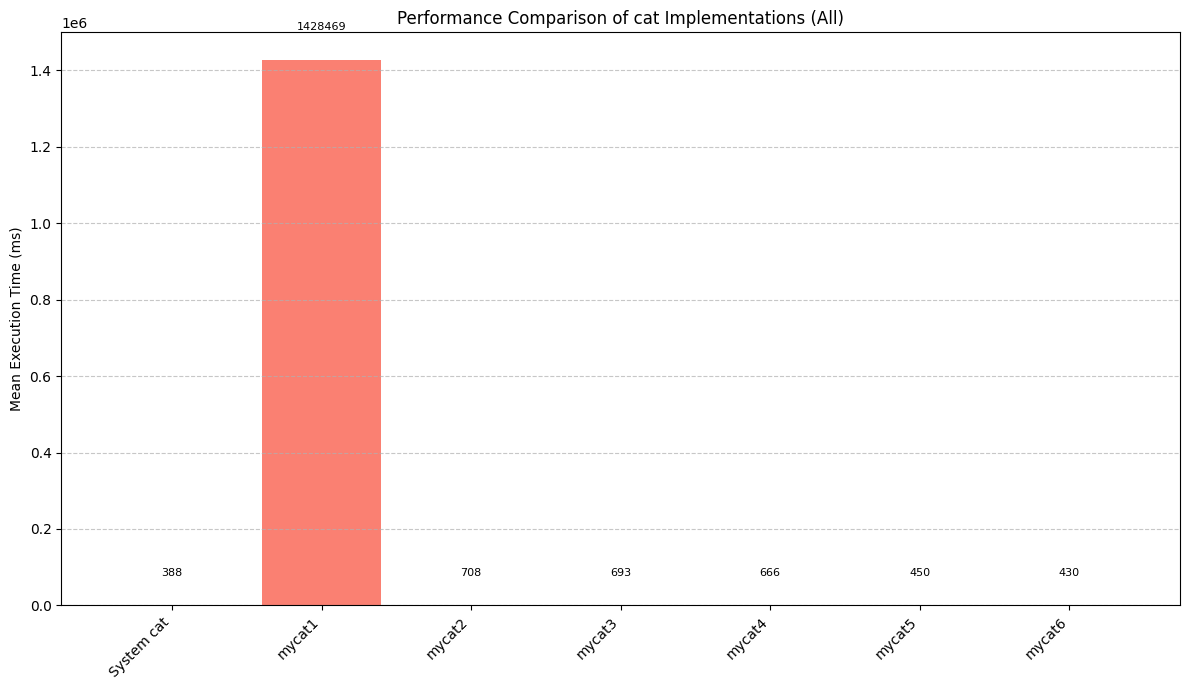

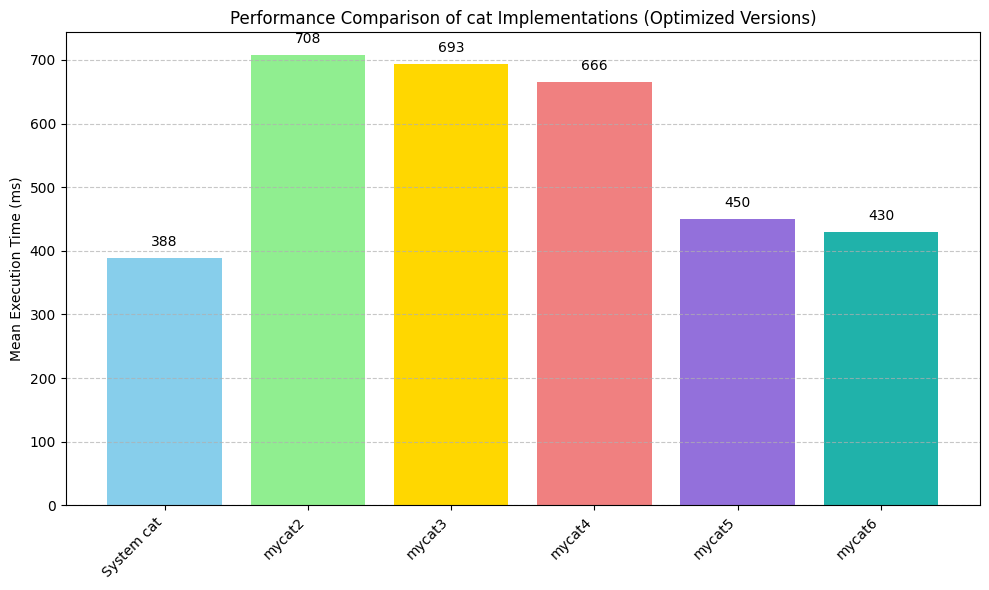

In [ ]:
# 这里填入你用于画图的python代码
import matplotlib.pyplot as plt
import numpy as np

# --- REPLACE WITH YOUR ACTUAL MEASURED MEAN TIMES IN MILLISECONDS ---
programs = ['System cat', 'mycat1', 'mycat2', 'mycat3', 'mycat4', 'mycat5', 'mycat6']
# Times in milliseconds for better scale on y-axis if mycat1 is included
times_ms = [
    388,      # System cat
    1428469,  # mycat1 (char-by-char)
    708,      # mycat2 (page-size buffer)
    693,      # mycat3 (aligned page-size buffer)
    666,      # mycat4 (fs_block_size aware, aligned)
    450,      # mycat5 (256KB buffer, aligned) - EXAMPLE, use your value
    430       # mycat6 (256KB buffer, aligned, fadvise) - EXAMPLE, use your value
]
# --- END OF DATA TO REPLACE ---

# If mycat1's time is excessively large, it will dwarf other bars.
# Consider plotting two charts: one with all, one without mycat1 for better detail.

# Plot 1: All programs
plt.figure(figsize=(12, 7))
bars = plt.bar(programs, times_ms, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'mediumpurple', 'lightseagreen'])
plt.ylabel('Mean Execution Time (ms)')
plt.title('Performance Comparison of cat Implementations (All)')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05 * max(times_ms), f'{yval:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('mycat_performance_all.png')
print("Plot 'mycat_performance_all.png' saved.")
# plt.show()

# Plot 2: Excluding mycat1 for better detail on optimized versions
programs_optimized = programs[0:1] + programs[2:] # System cat + mycat2 onwards
times_ms_optimized = times_ms[0:1] + times_ms[2:]

plt.figure(figsize=(10, 6))
bars_optimized = plt.bar(programs_optimized, times_ms_optimized, color=['skyblue', 'lightgreen', 'gold', 'lightcoral', 'mediumpurple', 'lightseagreen'])
plt.ylabel('Mean Execution Time (ms)')
plt.title('Performance Comparison of cat Implementations (Optimized Versions)')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on bars for the optimized plot
for bar in bars_optimized:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02 * max(times_ms_optimized), f'{yval:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('mycat_performance_optimized.png')
print("Plot 'mycat_performance_optimized.png' saved.")
# plt.show()